In [12]:
import copy
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sys
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [13]:
class DASTModel():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = 'norm' if is_norm else ''
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_2560.npy'))
        feature2 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_1280.npy'))
        feature3 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_640.npy'))
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _norm(self, array):
        feat_len = array.shape[2]
        x = array.reshape(-1, feat_len)
        min_vals = np.min(x, axis=1, keepdims=True)
        max_vals = np.max(x, axis=1, keepdims=True)
        normalized_array = (x - min_vals) / (max_vals - min_vals)
        # print('min=======')
        # print(min_array)
        # print('max=======')
        # print(max_array)
        original_shape_array = normalized_array.reshape(-1, 40, feat_len)
        return original_shape_array
        
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            # print(X_train.shape)
            # print(X_train[0][0])
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        print(f"{self.best_train_loss:.7f}")
        print(f"{self.best_mse_loss:.7f}")
        print(f"{self.best_rmse_loss:.7f}")

In [14]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 20
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [15]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
# TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
# TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
# TRAIN_DATASETS = ['Bearing2_1', 'Bearing2_2']
# TEST_DATASET = ['Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7']
TRAIN_DATASETS = ['Bearing3_1', 'Bearing3_2']
TEST_DATASET = ['Bearing3_3']

MODEL_SAVE_NAME = f'Bearing{TRAIN_DATASETS[0][7]}_pretrain_{len(selected_indices)}_batch_norm'
IS_NORM = True
MODEL_SAVE_PATH = '../../../model/norm'

In [16]:
dast_model = DASTModel(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME)

In [17]:
dast_model.main(selected_indices)

100%|██████████| 9/9 [00:00<00:00, 12.87it/s]


epoch =  0 train_loss =  0.12988204705632395
rmse_loss =  0.24407775700092316 mae_loss =  0.23161420226097107 mse_loss =  0.0595739521086216


100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


epoch =  1 train_loss =  0.14720938458210892
rmse_loss =  0.1547684520483017 mae_loss =  0.11235270649194717 mse_loss =  0.02395327389240265


100%|██████████| 9/9 [00:00<00:00, 13.03it/s]


epoch =  2 train_loss =  0.06095058482605964
rmse_loss =  0.10801848024129868 mae_loss =  0.07695325464010239 mse_loss =  0.011667991988360882


100%|██████████| 9/9 [00:00<00:00, 14.60it/s]


epoch =  3 train_loss =  0.05062539500391318
rmse_loss =  0.1298128068447113 mae_loss =  0.09052107483148575 mse_loss =  0.016851365566253662


100%|██████████| 9/9 [00:00<00:00, 14.52it/s]


epoch =  4 train_loss =  0.05098600147498979
rmse_loss =  0.1244778260588646 mae_loss =  0.08482041954994202 mse_loss =  0.01549472939223051


100%|██████████| 9/9 [00:00<00:00, 13.87it/s]


epoch =  5 train_loss =  0.036255657103740506
rmse_loss =  0.14216186106204987 mae_loss =  0.10434044897556305 mse_loss =  0.02020999602973461


100%|██████████| 9/9 [00:00<00:00, 14.67it/s]


epoch =  6 train_loss =  0.041726175954358444
rmse_loss =  0.12192944437265396 mae_loss =  0.0905555859208107 mse_loss =  0.014866788871586323


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


epoch =  7 train_loss =  0.034118195788727865
rmse_loss =  0.1588929146528244 mae_loss =  0.12338315695524216 mse_loss =  0.025246957316994667


100%|██████████| 9/9 [00:00<00:00, 18.08it/s]


epoch =  8 train_loss =  0.03166614620325466
rmse_loss =  0.18172192573547363 mae_loss =  0.15845847129821777 mse_loss =  0.03302285820245743


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


epoch =  9 train_loss =  0.03393871559657984
rmse_loss =  0.17827968299388885 mae_loss =  0.1543993055820465 mse_loss =  0.03178364410996437


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


epoch =  10 train_loss =  0.02936784302194913
rmse_loss =  0.20738928020000458 mae_loss =  0.1826077252626419 mse_loss =  0.04301031306385994


100%|██████████| 9/9 [00:00<00:00, 17.90it/s]


epoch =  11 train_loss =  0.02994029733559324
rmse_loss =  0.21687862277030945 mae_loss =  0.19691918790340424 mse_loss =  0.04703633487224579


100%|██████████| 9/9 [00:00<00:00, 18.01it/s]


epoch =  12 train_loss =  0.030589931696239445
rmse_loss =  0.2129780352115631 mae_loss =  0.19024702906608582 mse_loss =  0.045359641313552856


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


epoch =  13 train_loss =  0.027519489793727796
rmse_loss =  0.2357991486787796 mae_loss =  0.2147936224937439 mse_loss =  0.05560123547911644


100%|██████████| 9/9 [00:00<00:00, 17.74it/s]


epoch =  14 train_loss =  0.02937209104291267
rmse_loss =  0.2324991673231125 mae_loss =  0.21261480450630188 mse_loss =  0.05405586212873459


100%|██████████| 9/9 [00:00<00:00, 17.68it/s]


epoch =  15 train_loss =  0.027932248000676434
rmse_loss =  0.23521341383457184 mae_loss =  0.2129935324192047 mse_loss =  0.055325351655483246


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


epoch =  16 train_loss =  0.02663154931118091
rmse_loss =  0.2530614137649536 mae_loss =  0.23288249969482422 mse_loss =  0.06404007971286774


100%|██████████| 9/9 [00:00<00:00, 18.16it/s]


epoch =  17 train_loss =  0.028376966818339296
rmse_loss =  0.24017101526260376 mae_loss =  0.21885235607624054 mse_loss =  0.05768211558461189


100%|██████████| 9/9 [00:00<00:00, 18.22it/s]


epoch =  18 train_loss =  0.02561879983275301
rmse_loss =  0.2564435303211212 mae_loss =  0.23491045832633972 mse_loss =  0.06576328724622726


100%|██████████| 9/9 [00:00<00:00, 17.95it/s]


epoch =  19 train_loss =  0.02666703427934812
rmse_loss =  0.26047059893608093 mae_loss =  0.2392733246088028 mse_loss =  0.0678449273109436


100%|██████████| 9/9 [00:00<00:00, 18.33it/s]


epoch =  20 train_loss =  0.026302271807152364
rmse_loss =  0.25267264246940613 mae_loss =  0.22984027862548828 mse_loss =  0.06384345889091492


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  21 train_loss =  0.02448869299971395
rmse_loss =  0.27625590562820435 mae_loss =  0.25393590331077576 mse_loss =  0.07631732523441315


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch =  22 train_loss =  0.026604617480188608
rmse_loss =  0.25897136330604553 mae_loss =  0.23586486279964447 mse_loss =  0.06706617027521133


100%|██████████| 9/9 [00:00<00:00, 18.87it/s]


epoch =  23 train_loss =  0.02376266706010534
rmse_loss =  0.2760157287120819 mae_loss =  0.25254014134407043 mse_loss =  0.07618468254804611


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  24 train_loss =  0.025044566486030817
rmse_loss =  0.2803323268890381 mae_loss =  0.2562183737754822 mse_loss =  0.07858621329069138


100%|██████████| 9/9 [00:00<00:00, 18.85it/s]


epoch =  25 train_loss =  0.024538566461867757
rmse_loss =  0.2679566442966461 mae_loss =  0.24296867847442627 mse_loss =  0.07180076837539673


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  26 train_loss =  0.02291740368430813
rmse_loss =  0.29841604828834534 mae_loss =  0.27264413237571716 mse_loss =  0.08905213326215744


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  27 train_loss =  0.025373646239232685
rmse_loss =  0.2680339515209198 mae_loss =  0.24200357496738434 mse_loss =  0.07184220105409622


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  28 train_loss =  0.02179936130738093
rmse_loss =  0.30000439286231995 mae_loss =  0.2733714282512665 mse_loss =  0.0900026336312294


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  29 train_loss =  0.024535768018621538
rmse_loss =  0.28707072138786316 mae_loss =  0.25966131687164307 mse_loss =  0.08240960538387299


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch =  30 train_loss =  0.022288780400736466
rmse_loss =  0.2872169315814972 mae_loss =  0.2596817910671234 mse_loss =  0.08249357342720032


100%|██████████| 9/9 [00:00<00:00, 18.87it/s]


epoch =  31 train_loss =  0.02236332232132554
rmse_loss =  0.31547799706459045 mae_loss =  0.2852414548397064 mse_loss =  0.09952636063098907


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  32 train_loss =  0.023936732723895047
rmse_loss =  0.27223774790763855 mae_loss =  0.24272212386131287 mse_loss =  0.0741133987903595


100%|██████████| 9/9 [00:00<00:00, 18.88it/s]


epoch =  33 train_loss =  0.020366928721260693
rmse_loss =  0.3333130180835724 mae_loss =  0.3009294271469116 mse_loss =  0.11109756678342819


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  34 train_loss =  0.02509040314341999
rmse_loss =  0.271089643239975 mae_loss =  0.24051697552204132 mse_loss =  0.07348959147930145


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  35 train_loss =  0.019397474877122376
rmse_loss =  0.3288280963897705 mae_loss =  0.2965993881225586 mse_loss =  0.10812791436910629


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  36 train_loss =  0.02412402556122591
rmse_loss =  0.29547667503356934 mae_loss =  0.26315736770629883 mse_loss =  0.08730646967887878


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  37 train_loss =  0.02043604475653006
rmse_loss =  0.30615565180778503 mae_loss =  0.27443668246269226 mse_loss =  0.09373129159212112


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  38 train_loss =  0.02171682830279072
rmse_loss =  0.3416326642036438 mae_loss =  0.30383580923080444 mse_loss =  0.11671288311481476


100%|██████████| 9/9 [00:00<00:00, 18.95it/s]


epoch =  39 train_loss =  0.023559600683963962
rmse_loss =  0.2758806347846985 mae_loss =  0.24041636288166046 mse_loss =  0.07611013203859329


100%|██████████| 9/9 [00:00<00:00, 18.95it/s]


epoch =  40 train_loss =  0.019257915581369564
rmse_loss =  0.38513627648353577 mae_loss =  0.3430268466472626 mse_loss =  0.1483299434185028


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  41 train_loss =  0.02723972654591004
rmse_loss =  0.2451442927122116 mae_loss =  0.20707134902477264 mse_loss =  0.06009572744369507


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  42 train_loss =  0.017758660212469597
rmse_loss =  0.37048038840293884 mae_loss =  0.3311459720134735 mse_loss =  0.1372557282447815


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  43 train_loss =  0.027611006905014317
rmse_loss =  0.27094289660453796 mae_loss =  0.23537899553775787 mse_loss =  0.07341005653142929


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  44 train_loss =  0.018389526107865903
rmse_loss =  0.33806318044662476 mae_loss =  0.30288463830947876 mse_loss =  0.11428670585155487


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  45 train_loss =  0.0241850558668375
rmse_loss =  0.3482714593410492 mae_loss =  0.30373117327690125 mse_loss =  0.12129300832748413


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  46 train_loss =  0.022743004167245492
rmse_loss =  0.2876591384410858 mae_loss =  0.24819597601890564 mse_loss =  0.08274777233600616


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch =  47 train_loss =  0.01971377621197866
rmse_loss =  0.4338054358959198 mae_loss =  0.3826720416545868 mse_loss =  0.18818716704845428


100%|██████████| 9/9 [00:00<00:00, 18.90it/s]


epoch =  48 train_loss =  0.028457913043287892
rmse_loss =  0.2126278579235077 mae_loss =  0.17003630101680756 mse_loss =  0.04521060734987259


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  49 train_loss =  0.01898455368872318
rmse_loss =  0.34410274028778076 mae_loss =  0.30629584193229675 mse_loss =  0.11840670555830002


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  50 train_loss =  0.029101936612278223
rmse_loss =  0.2940213680267334 mae_loss =  0.2532558739185333 mse_loss =  0.0864485651254654


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  51 train_loss =  0.017395221007366974
rmse_loss =  0.3500021994113922 mae_loss =  0.314055860042572 mse_loss =  0.12250152975320816


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  52 train_loss =  0.02525891477449073
rmse_loss =  0.38898852467536926 mae_loss =  0.3352569341659546 mse_loss =  0.15131208300590515


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  53 train_loss =  0.02237239009183314
rmse_loss =  0.26572415232658386 mae_loss =  0.2214626520872116 mse_loss =  0.07060932368040085


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  54 train_loss =  0.01878607208426628
rmse_loss =  0.4223896861076355 mae_loss =  0.37329864501953125 mse_loss =  0.1784130483865738


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch =  55 train_loss =  0.028458460027145013
rmse_loss =  0.2224559783935547 mae_loss =  0.1828266680240631 mse_loss =  0.049486663192510605


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  56 train_loss =  0.01641949986676789
rmse_loss =  0.34714698791503906 mae_loss =  0.30700215697288513 mse_loss =  0.12051103264093399


100%|██████████| 9/9 [00:00<00:00, 18.86it/s]


epoch =  57 train_loss =  0.024866746195281546
rmse_loss =  0.3208044171333313 mae_loss =  0.2749773859977722 mse_loss =  0.10291548073291779


100%|██████████| 9/9 [00:00<00:00, 18.88it/s]


epoch =  58 train_loss =  0.01576979748076863
rmse_loss =  0.33153411746025085 mae_loss =  0.2923597991466522 mse_loss =  0.1099148690700531


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  59 train_loss =  0.01969325200965007
rmse_loss =  0.3891608417034149 mae_loss =  0.3345646858215332 mse_loss =  0.1514461636543274


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  60 train_loss =  0.019435555570655398
rmse_loss =  0.2799564599990845 mae_loss =  0.23711705207824707 mse_loss =  0.07837561517953873


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  61 train_loss =  0.01608398261790474
rmse_loss =  0.3941560685634613 mae_loss =  0.3430689573287964 mse_loss =  0.15535899996757507


100%|██████████| 9/9 [00:00<00:00, 18.90it/s]


epoch =  62 train_loss =  0.021999488985683355
rmse_loss =  0.27881675958633423 mae_loss =  0.23543348908424377 mse_loss =  0.07773879170417786


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  63 train_loss =  0.014204289958191415
rmse_loss =  0.3624935746192932 mae_loss =  0.3154343068599701 mse_loss =  0.13140159845352173


100%|██████████| 9/9 [00:00<00:00, 18.84it/s]


epoch =  64 train_loss =  0.019603809936799936
rmse_loss =  0.33448079228401184 mae_loss =  0.28386521339416504 mse_loss =  0.11187740415334702


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch =  65 train_loss =  0.014783658294214143
rmse_loss =  0.3441256582736969 mae_loss =  0.29701247811317444 mse_loss =  0.11842247098684311


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  66 train_loss =  0.016331876653970942
rmse_loss =  0.3730807304382324 mae_loss =  0.3179333209991455 mse_loss =  0.1391892284154892


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  67 train_loss =  0.01669347564327634
rmse_loss =  0.3235861361026764 mae_loss =  0.2752658724784851 mse_loss =  0.1047079861164093


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  68 train_loss =  0.014230863708588812
rmse_loss =  0.38332995772361755 mae_loss =  0.3274078667163849 mse_loss =  0.14694185554981232


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch =  69 train_loss =  0.01732075456271155
rmse_loss =  0.32622164487838745 mae_loss =  0.2744450867176056 mse_loss =  0.10642056167125702


100%|██████████| 9/9 [00:00<00:00, 18.90it/s]


epoch =  70 train_loss =  0.013858439277909283
rmse_loss =  0.3806665241718292 mae_loss =  0.32313302159309387 mse_loss =  0.14490701258182526


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  71 train_loss =  0.016059775746220514
rmse_loss =  0.3488287627696991 mae_loss =  0.2911224365234375 mse_loss =  0.12168151140213013


100%|██████████| 9/9 [00:00<00:00, 17.15it/s]


epoch =  72 train_loss =  0.014515333576127887
rmse_loss =  0.3814471364021301 mae_loss =  0.3199946880340576 mse_loss =  0.14550191164016724


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


epoch =  73 train_loss =  0.014272848053628372
rmse_loss =  0.3667549192905426 mae_loss =  0.3037112057209015 mse_loss =  0.1345091611146927


100%|██████████| 9/9 [00:00<00:00, 18.90it/s]


epoch =  74 train_loss =  0.01491259452369478
rmse_loss =  0.39238980412483215 mae_loss =  0.32353952527046204 mse_loss =  0.15396976470947266


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  75 train_loss =  0.013349375674604542
rmse_loss =  0.37825196981430054 mae_loss =  0.30958619713783264 mse_loss =  0.14307455718517303


100%|██████████| 9/9 [00:00<00:00, 18.90it/s]


epoch =  76 train_loss =  0.014318191174728176
rmse_loss =  0.4153873324394226 mae_loss =  0.3371240794658661 mse_loss =  0.1725466251373291


100%|██████████| 9/9 [00:00<00:00, 18.79it/s]


epoch =  77 train_loss =  0.014691466181021597
rmse_loss =  0.38364142179489136 mae_loss =  0.31115132570266724 mse_loss =  0.1471807360649109


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  78 train_loss =  0.013716458873305883
rmse_loss =  0.43175286054611206 mae_loss =  0.34762391448020935 mse_loss =  0.18641053140163422


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


epoch =  79 train_loss =  0.018119192255350452
rmse_loss =  0.38619664311408997 mae_loss =  0.3150392174720764 mse_loss =  0.1491478532552719


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch =  80 train_loss =  0.012565592323274663
rmse_loss =  0.45187222957611084 mae_loss =  0.36654382944107056 mse_loss =  0.2041885107755661


100%|██████████| 9/9 [00:00<00:00, 18.97it/s]


epoch =  81 train_loss =  0.017391557326643832
rmse_loss =  0.32549068331718445 mae_loss =  0.2604731321334839 mse_loss =  0.1059441864490509


100%|██████████| 9/9 [00:00<00:00, 18.73it/s]


epoch =  82 train_loss =  0.01149250726060321
rmse_loss =  0.44517242908477783 mae_loss =  0.3617378771305084 mse_loss =  0.1981784999370575


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


epoch =  83 train_loss =  0.01505464634909812
rmse_loss =  0.4011869430541992 mae_loss =  0.319995254278183 mse_loss =  0.16095097362995148


100%|██████████| 9/9 [00:00<00:00, 18.77it/s]


epoch =  84 train_loss =  0.01156979576141263
rmse_loss =  0.3726169764995575 mae_loss =  0.29420459270477295 mse_loss =  0.13884341716766357


100%|██████████| 9/9 [00:00<00:00, 18.39it/s]


epoch =  85 train_loss =  0.01621798371585707
rmse_loss =  0.430594265460968 mae_loss =  0.3430767059326172 mse_loss =  0.18541142344474792


100%|██████████| 9/9 [00:00<00:00, 13.54it/s]


epoch =  86 train_loss =  0.01738835596996877
rmse_loss =  0.3933998644351959 mae_loss =  0.326272189617157 mse_loss =  0.15476344525814056


100%|██████████| 9/9 [00:00<00:00, 13.42it/s]


epoch =  87 train_loss =  0.015112540154303942
rmse_loss =  0.4282476007938385 mae_loss =  0.3488265573978424 mse_loss =  0.18339601159095764


100%|██████████| 9/9 [00:00<00:00, 13.88it/s]


epoch =  88 train_loss =  0.021499926431311503
rmse_loss =  0.41041332483291626 mae_loss =  0.33956918120384216 mse_loss =  0.1684391051530838


100%|██████████| 9/9 [00:00<00:00, 12.95it/s]


epoch =  89 train_loss =  0.011768165742978454
rmse_loss =  0.4607788324356079 mae_loss =  0.38048189878463745 mse_loss =  0.21231713891029358


100%|██████████| 9/9 [00:00<00:00, 13.41it/s]


epoch =  90 train_loss =  0.02640843449626118
rmse_loss =  0.3166530132293701 mae_loss =  0.257233202457428 mse_loss =  0.1002691239118576


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]


epoch =  91 train_loss =  0.017962672527775995
rmse_loss =  0.46485552191734314 mae_loss =  0.4069651961326599 mse_loss =  0.21609064936637878


100%|██████████| 9/9 [00:00<00:00, 13.67it/s]


epoch =  92 train_loss =  0.0188140405031542
rmse_loss =  0.4303739368915558 mae_loss =  0.3679398000240326 mse_loss =  0.18522171676158905


100%|██████████| 9/9 [00:00<00:00, 13.28it/s]


epoch =  93 train_loss =  0.019212379042680066
rmse_loss =  0.3538173735141754 mae_loss =  0.2904806137084961 mse_loss =  0.1251867264509201


100%|██████████| 9/9 [00:00<00:00, 13.90it/s]


epoch =  94 train_loss =  0.012952385347388271
rmse_loss =  0.36970940232276917 mae_loss =  0.3084148168563843 mse_loss =  0.13668504357337952


100%|██████████| 9/9 [00:00<00:00, 13.34it/s]


epoch =  95 train_loss =  0.014860225181716183
rmse_loss =  0.40717536211013794 mae_loss =  0.32841578125953674 mse_loss =  0.16579177975654602


100%|██████████| 9/9 [00:00<00:00, 13.26it/s]


epoch =  96 train_loss =  0.011329164909612801
rmse_loss =  0.41244420409202576 mae_loss =  0.3382017910480499 mse_loss =  0.17011022567749023


100%|██████████| 9/9 [00:00<00:00, 13.43it/s]


epoch =  97 train_loss =  0.011992595287867718
rmse_loss =  0.4494660794734955 mae_loss =  0.3576176166534424 mse_loss =  0.20201975107192993


100%|██████████| 9/9 [00:00<00:00, 13.86it/s]


epoch =  98 train_loss =  0.012165171986756226
rmse_loss =  0.42718204855918884 mae_loss =  0.3360845148563385 mse_loss =  0.1824844926595688


100%|██████████| 9/9 [00:00<00:00, 13.21it/s]

epoch =  99 train_loss =  0.010442370898090303
rmse_loss =  0.4199222922325134 mae_loss =  0.3272070586681366 mse_loss =  0.17633472383022308
train time: 0.5247752, s/epoch
embed1: 20, embed2: 20, lr: 0.001, dec_seq_len: 6
0.0104424
0.0116680
0.1080185


In [18]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

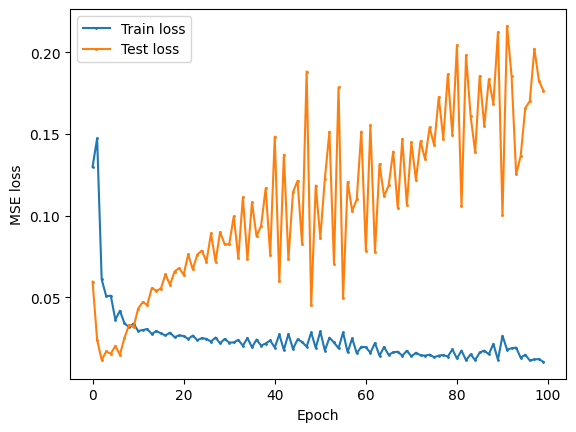

In [19]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

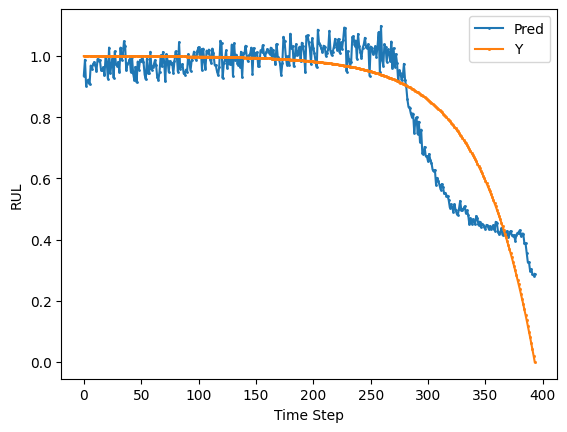

In [20]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

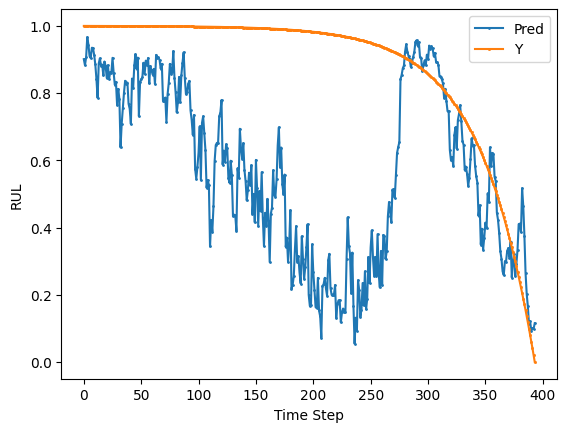

In [21]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [22]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")

0.0104424
0.0116680
0.1080185


In [ ]:
# Run above